In [1]:
import os

import torch
import numpy as np
from offline.convert_datset import merge_rllib_out
from dynamic_programming.policy_iteration import PolicyIteration, PolicyIterationTorch
from dynamic_programming.mdp_model import MDPModel, DPPolicy

import time

## Load Data and MDP Model

In [2]:
device = 'cpu'
load_path = os.path.join("tmp", "ibqf-out/ibq_samples.npy")
#load_path = os.path.join("tmp", "ibq_samples_50m.npy")
mdp_save_path = 'dynamic_programming/mdp_model.pkl'
sa_reward = False
samples = np.load(load_path,allow_pickle=True)[()]


print(samples['rewards'].mean())
print(samples['rewards'].size)
samples['rewards'] = samples['rewards'] + np.abs(samples['rewards'].min())
print(samples['rewards'].min())
print(np.unique(samples['obs']).size)

-343.80504743029906
20010000
0.0
800


In [3]:
start = time.time()
mdp_model = MDPModel(states=samples['obs'], next_states=samples['new_obs'], actions=samples['actions'],
                     rewards=samples['rewards'], dones=samples['dones'], device=device, sa_reward=sa_reward)

end = time.time()
print(end - start)


Computing Reward Function
Computing Transition Model
569.6408190727234


In [4]:
mdp_model.save(mdp_save_path)

In [5]:
mdp_model = MDPModel.load(mdp_save_path)
# mdp_model.reward_function = torch.nan_to_num(mdp_model.reward_function, nan=samples['rewards'].min())
# mdp_model.transition_model = torch.nan_to_num(mdp_model.transition_model)

## Train

In [6]:
mdp_model.reward_function.shape

(800,)

In [7]:
mdp_model.reward_function

array([2359.0735 , 2354.2844 , 2329.9111 , 2275.2966 , 2605.841  ,
       2546.5107 , 2590.2495 , 2399.6692 , 2382.8264 , 2448.8289 ,
       2410.7866 , 2494.5674 , 2566.9094 , 2603.416  , 2614.9634 ,
       2465.0408 , 2495.6138 , 2477.1064 , 2558.0144 , 2507.344  ,
       2571.2087 , 2532.8516 , 2523.4194 , 2568.0022 , 2547.3352 ,
       2512.2542 , 2544.5044 , 2526.378  , 2533.2568 , 2506.977  ,
       2538.5938 , 2506.0151 , 2561.7676 , 2507.5522 , 2369.124  ,
       2346.6738 , 2375.0227 , 2356.8193 , 2508.5417 , 2490.538  ,
       2484.9102 , 2430.6523 , 2469.5833 , 2408.4873 , 2425.3684 ,
       2538.041  , 2531.4656 , 2511.3916 , 2527.9348 , 2497.6282 ,
       2529.447  , 2489.9707 , 2340.8635 , 2509.7646 , 2486.56   ,
       2505.5122 , 2464.8228 , 2538.4446 , 2491.151  , 2518.3916 ,
       2487.8853 , 2376.5818 , 2489.6555 , 2497.1248 , 2409.1458 ,
       2418.8157 , 2391.0383 , 2428.6382 , 2532.9927 , 2467.9578 ,
       2533.45   , 2462.163  , 2491.028  , 2448.1492 , 2438.53

7045.861260299338
4630.366767246954
4314.550902399949
4061.75044471822
3895.0573927258392
3701.0270162681445
3546.866857438399
3439.82842680256
3383.3971103510266
3356.3050697410436
3330.9469885772633
3306.9227481029957
3284.1065779737473
3262.4338828066757
3241.84395217953
3222.2739938988598
3203.662741310167
3185.952479905922
3171.9383707669986
3165.2829486779083
3158.3823292533416
3151.3031976276106
3144.0976078507665
3136.8061313390062
3129.46030104722
3122.08453103638
3114.697633932461
3107.3140241421643
3099.9446725451126
3092.5978633463674
3085.279792971647
3077.9950427673175
3070.74695095855
3063.5379043188877
3056.3695659957884
3049.2430526997923
3042.1590718522784
3035.1180271703633
3028.120099460779
3021.1653080168326
3014.2535569034226
3007.384669524894
3000.5584141565487
2993.7745225496183
2987.032703265053
2980.332651027653
2973.674053105933
2967.0565934950428
2960.4799555004865
2953.94382317923
2947.4478819848446
2940.9918188761803
2934.5753220831393
2928.198080670234
29

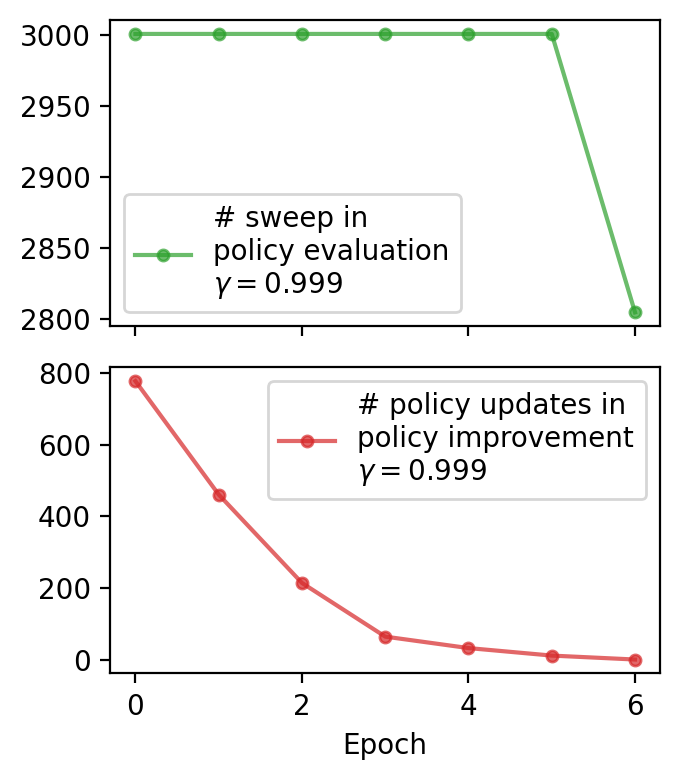

In [8]:
solver = PolicyIteration(mdp_model.reward_function, mdp_model.transition_model, gamma=0.999, sa_reward=sa_reward)
solver.train(total_epochs=100,eval_epochs=3000)
policy_save_path = 'dynamic_programming/ib_policy.pkl'

trained_policy = DPPolicy(policy_table=solver.policy, state_to_index=mdp_model.state_to_index,
                        index_to_action=mdp_model.index_to_actions)
trained_policy.save(policy_save_path)

In [9]:
print(solver.values)


[2552768.07462411 2553970.27210624 2554498.97550152 2554335.7278645
 2555543.53821311 2555507.17985596 2555270.515222   2554763.86441807
 2554791.60148857 2554679.97319915 2554819.56169365 2555409.29256635
 2555462.81428474 2555515.04659213 2555520.25353365 2555281.14505214
 2555452.18627513 2555308.98379053 2555494.56599834 2555443.89558819
 2555527.78124584 2555489.4240681  2555459.97102764 2555399.05476491
 2555512.08468854 2555491.58504483 2555443.55610832 2555386.89972023
 2555476.21079562 2555367.49884133 2555399.95688475 2555803.90338201
 2561767.50448956 2557466.91451048 2554545.30833504 2554579.18332795
 2554699.15303293 2554615.04637921 2555392.65231847 2555572.92374151
 2555416.87657454 2555448.00316151 2554558.76791287 2555162.16211143
 2554165.6392045  2555466.56960046 2555393.48612813 2555391.0320933
 2555611.50383347 2555380.06880758 2556213.11044734 2555366.80064974
 2555059.23328512 2555356.43050139 2555374.30895903 2555534.86585685
 2555112.87966107 2555308.97197807 2